# Gather data, determine the method of data collection and provenance of the data

* Problem: This competition seeks to understand the semantic similarity between phrases in patent documents. Because of the large volume of patents, having such classsification will help with the intensive vetting process for patents. The challenge lies in recognizing when different phrases mean the same thing, such as "television set" and "TV set," or when terms may vary in meaning based on their technical domain, like "strong material" which could refer to different substances depending on the context.

* Data Source: Data for this competition is derived from the public archives of the U.S. Patent and Trademark Office (USPTO). 

* Citation: Don Cenkci, Grigor Aslanyan, Ian Wetherbee, jm, Kiran Gunda, Maggie, Scott Beliveau, Will Cukierski. (2022). U.S. Patent Phrase to Phrase Matching . Kaggle. https://kaggle.com/competitions/us-patent-phrase-to-phrase-matching

# Identify a Deep Learning Problem

* Approach: The task of extracting semantic similarity from patent documents is a deep learning problem due to the complexity and subtlety of language interpretation required, which deep learning models are well-equipped to handle. After week 4 assignment, I was particularly interested in NLP and how more advanced transformer-based models can help to improve such tasks. I am also interested to see how new models on huggingface that are effectively and efficiently pre-trained can reduce time/effort to complete such tasks. I think this has much real-world application, especially in learning how transfer learning can be applied to domain-specific challenges. Specifically, I hope to delve deeper into 1 specific model - Deberta transformer model.

# Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data 

In [1]:
# libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings,transformers,logging,torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments,Trainer
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import time
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset
import gc
from torch.utils.data import DataLoader
from datasets import DatasetDict
import datasets

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [42]:
train_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')

test_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')

print(train_df.head())

print(train_df.info())

                 id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
None


In [3]:
missing_values = train_df.isnull().sum()
dataset_summary = train_df.describe(include='all')

missing_values, dataset_summary

(id         0
 anchor     0
 target     0
 context    0
 score      0
 dtype: int64,
                       id                       anchor       target context  \
 count              36473                        36473        36473   36473   
 unique             36473                          733        29340     106   
 top     37d61fd2272659b1  component composite coating  composition     H01   
 freq                   1                          152           24    2186   
 mean                 NaN                          NaN          NaN     NaN   
 std                  NaN                          NaN          NaN     NaN   
 min                  NaN                          NaN          NaN     NaN   
 25%                  NaN                          NaN          NaN     NaN   
 50%                  NaN                          NaN          NaN     NaN   
 75%                  NaN                          NaN          NaN     NaN   
 max                  NaN                     

There are a total of 36473 records with the following columns:
* id: A unique identifier for each phrase pair.
* anchor: The first phrase in the pair.
* target: The second phrase in the pair.
* context: The Cooperative Patent Classification (CPC) code providing the technical domain context.
* score: The semantic similarity score between the anchor and target phrases, ranging from 0 to 1.

Overview:
* No missing values.
* anchor column has 733 unique phrases.
* target column is more diverse with 29340 unique phrases.
* The CPC codes has 106 unique values, indicating the technical domains.
* The score column ranges from 0 to 1, with a mean of approximately 0.362.

Next, I will visualize the distribution of the similarity score (score column) to understand how the semantic similarity scores are distributed across the dataset. This will give us an idea of the balance of similarity scores in the training data.

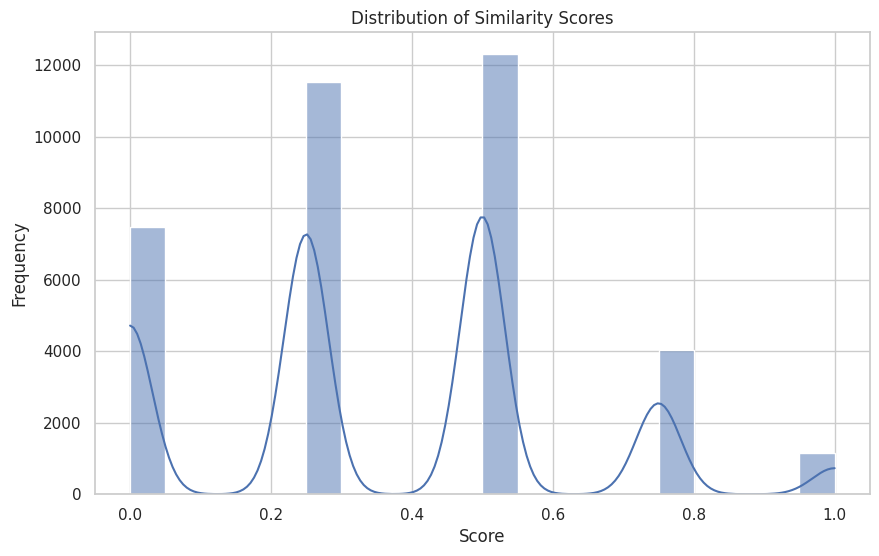

In [4]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df['score'], bins=20, kde=True)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

The histogram shows the distribution of similarity scores in the training data:

* Score Distribution: The scores are distributed between 0 and 1. We observe peaks at specific scores like 0.25, 0.5, and 1, suggesting that many phrase pairs have these specific similarity scores.
* Data Skewness: The distribution is somewhat skewed, with a higher concentration of scores around 0.25. This indicates that many phrase pairs are considered partially similar.

The results matches the score meaning provided by the patent office:

* 1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
* 0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
* 0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
* 0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
* 0.0 - Unrelated.

In [5]:
common_anchors = train_df['anchor'].value_counts().head(10)
common_targets = train_df['target'].value_counts().head(10)

common_anchors, common_targets

(anchor
 component composite coating    152
 sheet supply roller            150
 source voltage                 140
 perfluoroalkyl group           136
 el display                     135
 average pore size              133
 speed control means            130
 parallel orientation           127
 displacement mechanism         124
 cathode layer                  118
 Name: count, dtype: int64,
 target
 composition     24
 data            22
 metal           22
 motor           22
 assembly        21
 substrate       20
 component       19
 transmission    19
 output          19
 pressure        19
 Name: count, dtype: int64)

Next, we looked at the most common phrases in the anchor and target columns to understand them better:
* Common Anchors: Phrases like "component composite coating", "sheet supply roller", and "source voltage" are among the most frequent in the anchor column. These frequent anchors suggest certain themes or technical areas that are commonly addressed in patent documents.

* Common Targets: General terms like "composition", "data", "metal", and "motor" are among the most frequent in the target column. The target phrases appear to be more general and broadly applicable across different patents.

In [6]:
common_contexts = train_df['context'].value_counts().head(10)

common_contexts

context
H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
C07    1069
G06    1063
B60     916
B01     891
G02     877
Name: count, dtype: int64

Looking at the most common Contexts:
The top context codes are H01, H04, G01, A61, and F16. These codes represent different technical areas within the patent classification system.
H01 and H04 are particularly frequent, indicating a significant number of patent phrases related to electrical and electronic engineering fields.

Ref: https://www.uspto.gov/web/patents/classification/cpc/html/cpc.html

Next, we will analyze the lengths of the anchor and target phrases to see if there's a noticeable pattern or distribution. This can provide insights into the complexity of the phrases used in patent documents.

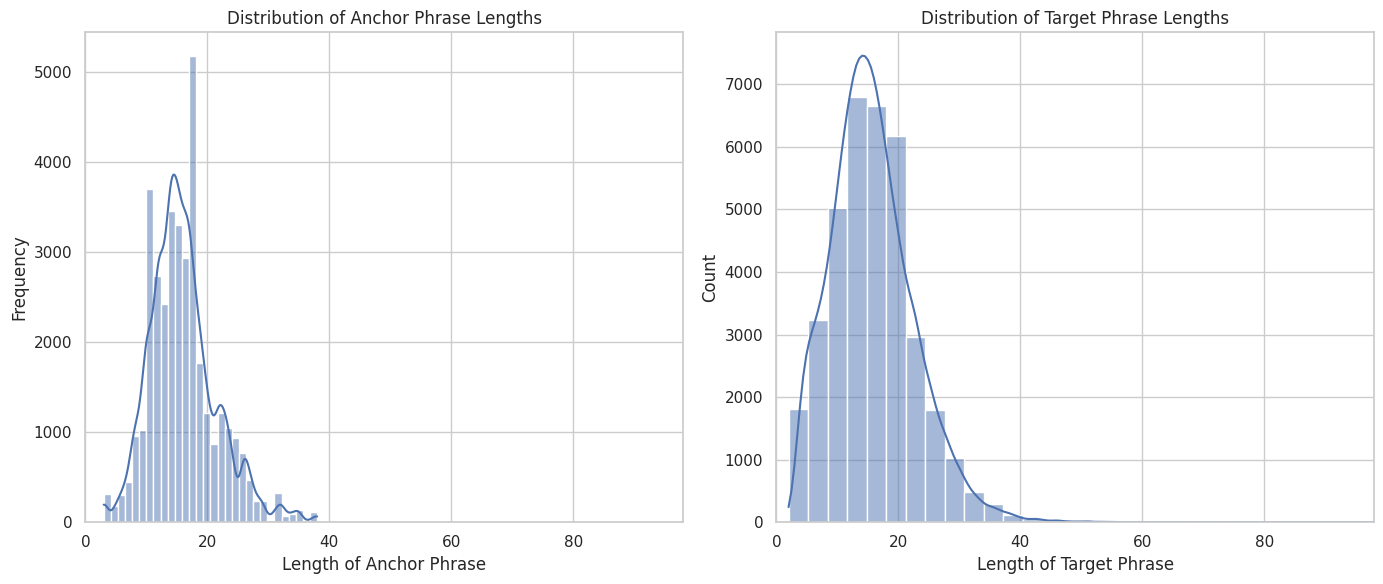

In [7]:
train_df['anchor_length'] = train_df['anchor'].apply(len)
train_df['target_length'] = train_df['target'].apply(len)

plt.figure(figsize=(14, 6))

max_length = max(train_df['anchor_length'].max(), train_df['target_length'].max())

plt.subplot(1, 2, 1)
sns.histplot(train_df['anchor_length'], bins=30, kde=True)
plt.title('Distribution of Anchor Phrase Lengths')
plt.xlabel('Length of Anchor Phrase')
plt.ylabel('Frequency')
plt.xlim(0, max_length)

plt.subplot(1, 2, 2)
sns.histplot(train_df['target_length'], bins=30, kde=True)
plt.title('Distribution of Target Phrase Lengths')
plt.xlabel('Length of Target Phrase')
plt.xlim(0, max_length)

plt.tight_layout()
plt.show()

* Anchor Phrase Lengths: The length of anchor phrases tends to be relatively short, with most lengths clustering around a lower range. This suggests that anchor phrases are typically concise.

* Target Phrase Lengths: The lengths of target phrases are also predominantly short but show a slightly wider distribution compared to anchor phrases. This indicates a bit more variability in the length of target phrases.

Note: 

Now, let's look at some examples of phrase pairs with high and low similarity scores. This will help us understand the criteria used for scoring similarity in this dataset. I will select a few examples of phrase pairs with the highest scores (close to 1) and the lowest scores (close to 0) to illustrate this. 

In [8]:
high_similarity_examples = train_df[train_df['score'] >= 0.9].sample(5, random_state=1)
low_similarity_examples = train_df[train_df['score'] <= 0.1].sample(5, random_state=1)

high_similarity_examples, low_similarity_examples

(                     id                   anchor                    target  \
 35185  d6942ff7d9bddbcf              video lines         video signal line   
 14696  a2d8462b917011bb               glass part               glass parts   
 19355  8401a36afab2f2e1             mat sections               mat section   
 5953   500279515b475671  color difference signal  color difference signals   
 18950  0e97ae2938e4d38e                main lane                main lanes   
 
       context  score  anchor_length  target_length  
 35185     G09    1.0             11             17  
 14696     G04    1.0             10             11  
 19355     A63    1.0             12             11  
 5953      H03    1.0             23             24  
 18950     E01    1.0              9             10  ,
                      id          anchor            target context  score  \
 4770   bf3fdc2e4b7cd659   cathode layer       outer layer     G01    0.0   
 2447   0795416ddc8d3926  average impact    a

* High Similarity Examples (Score ≥ 0.9):
    * Anchor: video lines | Target: video signal line
    * Anchor: glass part | Target: glass parts
    * Anchor: mat sections | Target: mat section
    * Anchor: color difference signal | Target: color difference signals
    * Anchor: main lane | Target: main lanes

These examples show that high similarity scores are often assigned to phrases that are very similar in wording and meaning, with differences mostly in plurality or slight variations in phrasing.

* Low Similarity Examples (Score ≤ 0.1):
    * Anchor: cathode layer | Target: outer layer
    * Anchor: average impact | Target: average scores
    * Anchor: well pump | Target: learning
    * Anchor: tubular billet | Target: billet doux
    * Anchor: flow openings | Target: air flow in nose

In contrast, low similarity scores are given to phrases that are quite different both in terms of wording and conceptual meaning.

Next, we will work on data preparation for the transformer models. We'll preprocess our dataset and tokenize the phrases for our 2 subsequent models.

Tokenization is a crucial preprocessing step in the context of transformer-based models, as it converts raw text into a format that the model can understand and process:

* Breaking Down Text: Tokenization starts by breaking down the input text into smaller units called tokens. These tokens can be words, subwords, or even characters, depending on the tokenization algorithm used.

* Subword Tokenization: Many transformer models, such as BERT and its variants, use a subword tokenization approach, which strikes a balance between word-level and character-level tokenization. This method helps in handling the vocabulary of large datasets efficiently and dealing with out-of-vocabulary (OOV) words. 

* Vocabulary Mapping: Each token is then mapped to an integer ID based on a predefined vocabulary. This vocabulary is built from the training corpus and includes a fixed set of tokens. Each token has a unique index in the vocabulary.

* Sequence Length Adjustment: Transformers require input sequences of a consistent length. If an input sequence is too long, it may be truncated to a maximum length. If it's too short, it will be padded with the pad token.

* Attention Masks: Since padding is used to create uniform sequence lengths, attention masks are also generated to tell the model which tokens are real and which are padding. This ensures that the model does not take the padding tokens into account when processing the input.

Once tokenized, the sequence of integer IDs (and potentially the attention masks) is fed into the transformer model, where it undergoes embedding and positional encoding before being processed by the attention and subsequent layers of the model. Tokenization is a foundational step that directly affects the performance of transformer-based models, as it determines how the raw text is represented and understood by the model.

Ref: https://huggingface.co/docs/transformers/tokenizer_summary

First, we load the deberta tokenizer.

In [9]:
model_path = '/kaggle/input/deberta-v3-small/deberta-v3-small'
tokenizer_deberta = AutoTokenizer.from_pretrained(model_path)

The next step is to combine the context, anchor, and target columns into a single column. This is crucial for the model to understand the relationship between these elements in the context of patents.

In [10]:
sep = tokenizer_deberta.sep_token
train_df['inputs'] = train_df['context'] + sep + train_df['anchor'] + sep + train_df['target']
test_df['inputs'] = test_df['context'] + sep + test_df['anchor'] + sep + test_df['target']

Besides that, it's more efficient to convert the pandas DataFrame into a HuggingFace Dataset. This format is more suitable for training transformer models. Additionally, I rename the score column to label as expected by the HuggingFace training process.

In [11]:
train_ds = Dataset.from_pandas(train_df.rename(columns={"score": "label"}))
test_ds = Dataset.from_pandas(test_df)

Next, I create a function to tokenize the inputs. This function will be applied to the dataset to prepare the data for the model.

In [12]:
def token_func(examples): 
    return tokenizer_deberta(examples['inputs'], padding='max_length', truncation=True, max_length=48)

Using the map function, I apply the tokenization to the dataset to speed things up. This step converts the text data into a format (like input_ids, attention_mask, etc.) that the model can process.

In [13]:
tokenized_train_ds = train_ds.map(token_func, batched=True)
tokenized_test_ds = test_ds.map(token_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
tokenized_train_ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'label': 0.5,
 'anchor_length': 9,
 'target_length': 22,
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution',
 'input_ids': [1,
  336,
  5753,
  2,
  47284,
  2,
  47284,
  265,
  6435,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

After tokenization, I remove columns that are no longer needed, such as the original text columns (anchor, target, context, inputs).

In [15]:
columns_to_remove = ["anchor", "target", "anchor_length", "target_length", "context", "inputs", "id"]
tokenized_train_ds = tokenized_train_ds.remove_columns(columns_to_remove)

In [16]:
tokenized_train_ds[0]

{'label': 0.5,
 'input_ids': [1,
  336,
  5753,
  2,
  47284,
  2,
  47284,
  265,
  6435,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

Next, we split the dataset into training and validation sets but retain them in a dataset dict for the modeling subsequently.

In [17]:
train_indices, val_indices = train_test_split(range(len(tokenized_train_ds)), test_size=0.2, random_state=42)

dataset_split = DatasetDict({"train":tokenized_train_ds.select(train_indices),"test": tokenized_train_ds.select(val_indices)})

# Perform Analysis Using Deep Learning Models

## BERT and DeBERTa V3

Before we delve into the first model, lets understand more about what DeBERTa V3 is.

First, transformers are a type of neural network architecture that have become the foundation for many state-of-the-art natural language processing (NLP) models. They were introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017. The key innovation of transformers is the attention mechanism, which allows the model to weigh the influence of different parts of the input data differently. 

BERT (Bidirectional Encoder Representations) utilizes the encoder component of the transformer architecture. The transformer encoder reads the entire sequence of words at once (hence the term "bidirectional") and uses self-attention mechanisms to understand the context around each word. The self-attention mechanism, which is central to the transformer model, allows BERT to weigh the influence of each word in a sentence on the others. This means that for any given word, BERT looks at the entire sentence to determine the context, rather than just the words before it (as in traditional left-to-right language models) or after it (as in right-to-left models). The transformer architecture, as used in BERT, is designed to be pre-trained on a large corpus of text and then fine-tuned for specific tasks like the one we have here.

DeBERTa (Decoding-Enhanced BERT with Disentangled Attention) is an advanced language representation model that builds upon the architecture of BERT. DeBERTa introduces two significant innovations to improve the model's understanding of word context and positional relationships within text:

* Disentangled Attention: The disentangled attention mechanism represents each word with two vectors: one for the word's content (the semantic meaning) and one for its position (the word's relative position in the sentence). Unlike BERT, which adds content and position embeddings together, DeBERTa treats these vectors separately throughout the network. This allows the model to compute attention weights based on four types of interactions: content-to-content, content-to-position, position-to-content, and position-to-position. However, the position-to-position attention is typically ignored since relative positions are used.

* Enhanced Masked Decoder (EMD): DeBERTa also modifies the masked language modeling (MLM) task used in BERT's pre-training. While BERT incorporates absolute position information at the input layer, DeBERTa introduces absolute position embeddings later in the model, after the transformer layers and just before the softmax layer used for predicting masked tokens. This design choice allows DeBERTa to focus on relative positions throughout the transformer layers and leverage absolute positions only when necessary for decoding masked words, hence the term "enhanced masked decoder".

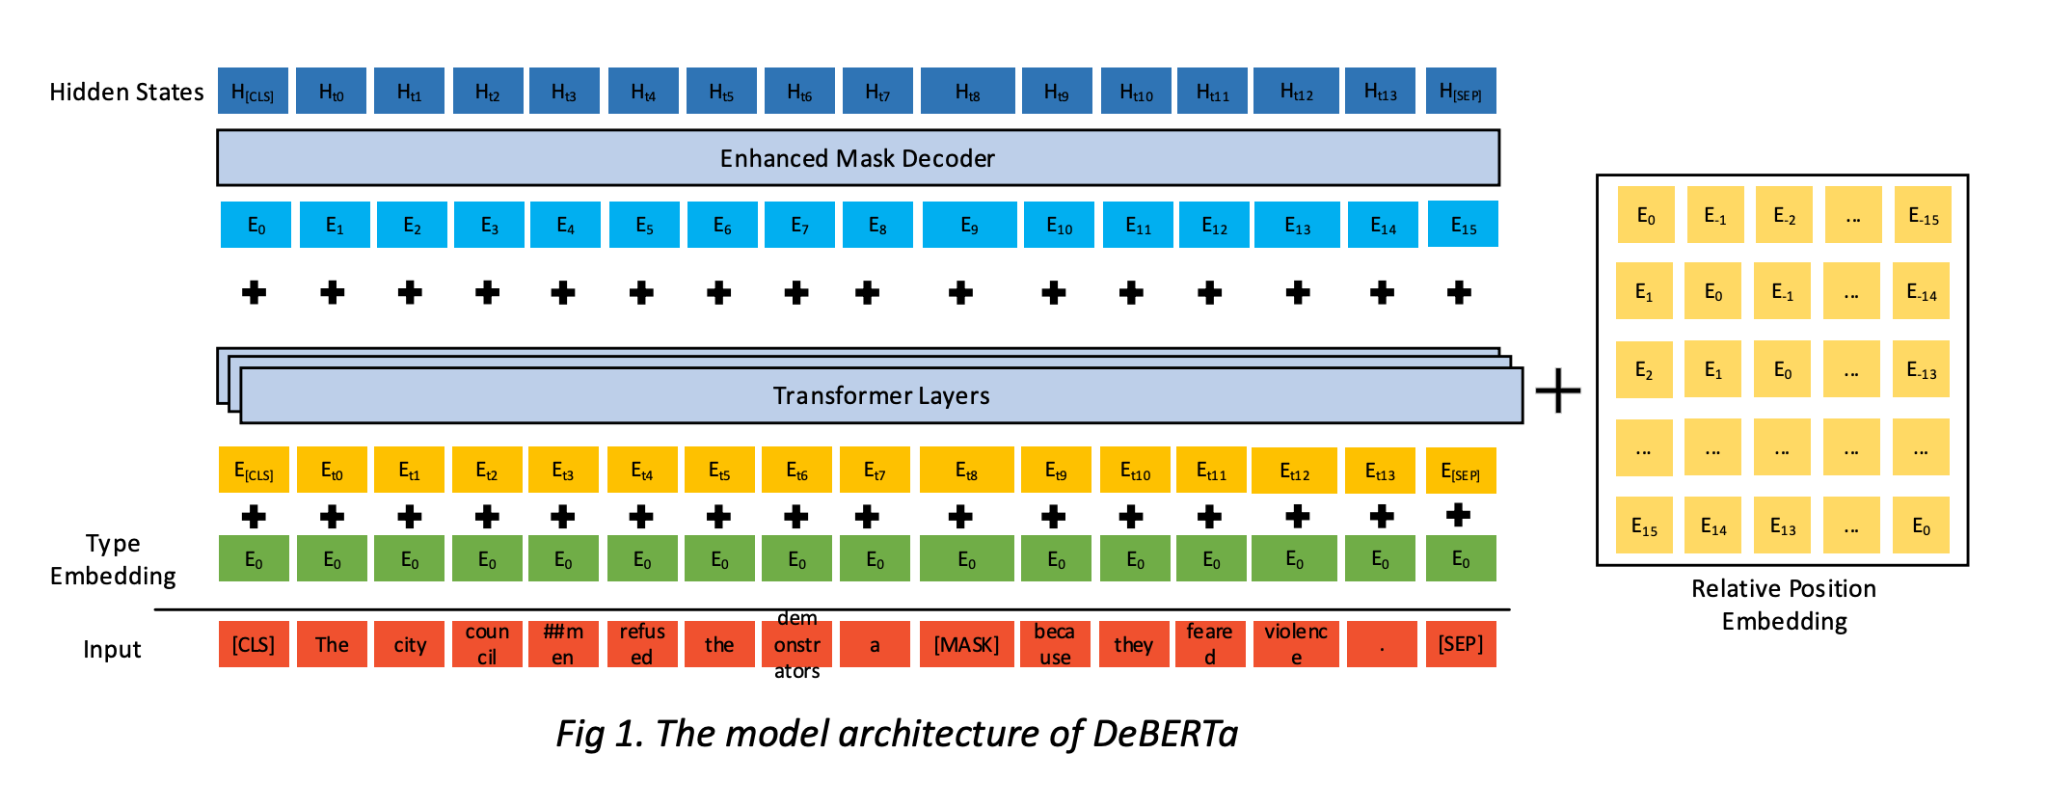

Image and information from wandb.ai article below.

Ref: 
* https://arxiv.org/abs/1706.03762
* https://blogs.nvidia.com/blog/what-is-a-transformer-model/
* https://huggingface.co/microsoft/deberta-v3-large
* https://wandb.ai/akshayuppal12/DeBERTa/reports/The-Next-Generation-of-Transformers-Leaving-BERT-Behind-With-DeBERTa--VmlldzoyNDM2NTk2#the-self-attention-in-bert-and-roberta?
* https://www.sbert.net/
* https://www.pinecone.io/learn/series/nlp/sentence-embeddings/
* https://github.com/huggingface/setfit
* https://towardsdatascience.com/sentence-transformer-fine-tuning-setfit-outperforms-gpt-3-on-few-shot-text-classification-while-d9a3788f0b4e

First, we define the correlation metric function for the Pearson correlation coefficient between the predicted and actual similarity.

In [18]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

Next, we set up the training arguments,load the pre-trained DeBERTa V3 using Hugging Face's Transformers library and set up the model. Hyperparameter tuning is discussed in the discussion section.

In [20]:
args = TrainingArguments('outputs', learning_rate=8e-5, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=False,
   evaluation_strategy="epoch", per_device_train_batch_size=256, per_device_eval_batch_size=256,
   num_train_epochs=5, weight_decay=0.01, report_to='none')

deberta_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
deberta_trainer = Trainer(deberta_model, args, train_dataset=dataset_split['train'], eval_dataset=dataset_split['test'],
               tokenizer=tokenizer_deberta, compute_metrics=corr)

And then we train the model with the built-in capabilities of the Hugging Face Trainer class.

In [21]:
training_outcome = deberta_trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026334,0.790490
2,No log,0.026128,0.816687
3,No log,0.021370,0.831483
4,No log,0.022663,0.836134
5,0.026100,0.022052,0.836314


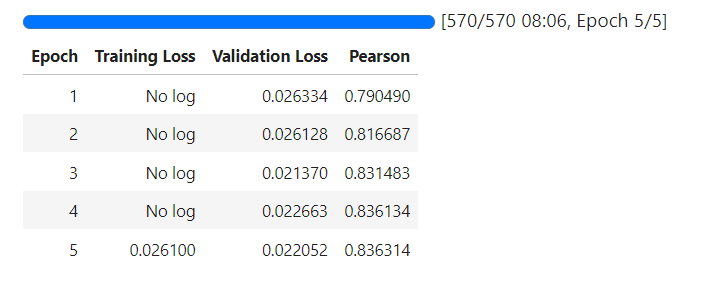

Strangely, the training log does not always record for each epoch. Running it a few times, it does so consistently for the first 2 epochs and may sometimes not record for subsequent ones too. Apparently, the Trainer class relies on the logging module to record training progress. If the logging level isn't set correctly or if the logger isn't configured to capture the training loss, it might not appear in the logs. However, as I did not conduct any customisation, it seens this might be due to some resource/version constraints.

Validation Loss: Over the five epochs, the validation loss decreases, which is a good sign that the model is learning and improving its predictions on the validation set. The range values are also very low, highlighting a consistent learning with little validation loss.

Pearson Correlation: More importantly, the correlation (ranging from approximately 0.79 to 0.84) indicate a strong positive correlation. This suggests that the model's predictions are well-aligned with the actual values. The Pearson coefficient is increasing over the epochs, which is a good sign that the model's predictive accuracy is improving.

With that, we will predict the test dataset with the deberta-v3-small model.

In [36]:
test_prediction = deberta_trainer.predict(tokenized_test_ds).predictions.astype(float)
test_prediction

array([[ 0.52920318],
       [ 0.77082157],
       [ 0.48740953],
       [ 0.29810575],
       [-0.02971622],
       [ 0.43567753],
       [ 0.45412499],
       [ 0.01079553],
       [ 0.29269877],
       [ 1.09834051],
       [ 0.2187766 ],
       [ 0.23010308],
       [ 0.79823321],
       [ 1.00193155],
       [ 0.80557293],
       [ 0.41278321],
       [ 0.27124882],
       [-0.03172402],
       [ 0.61369443],
       [ 0.3357752 ],
       [ 0.37590048],
       [ 0.23238692],
       [ 0.02530066],
       [ 0.21128061],
       [ 0.54638255],
       [-0.03386454],
       [-0.01756484],
       [-0.02878582],
       [-0.02394351],
       [ 0.62187839],
       [ 0.28831595],
       [ 0.00700764],
       [ 0.6461221 ],
       [ 0.53256482],
       [ 0.3701784 ],
       [ 0.2086488 ]])

As we have seen from the EDA, scores are scored at intervals of 0.25 from 0 to 1. Our predictions also contained figures outside of 0-1. 

Here, we round them to the nearest quarter by multiplying by 4, scaling to nearest interger and dividing by 4 again. While the current test data should all fall within the correct range, the competition submission might include new test data that may fall out of the range (e.g. rounded to 5 and become 1.25). Hence, I also apply clipping to ensure the results are 0-1 before flattening them for submission.

In [37]:
rounded_test_prediction = np.round(test_prediction * 4) / 4
rounded_test_prediction = np.clip(rounded_test_prediction, 0, 1)
rounded_test_prediction = rounded_test_prediction.flatten()
rounded_test_prediction

array([0.5 , 0.75, 0.5 , 0.25, 0.  , 0.5 , 0.5 , 0.  , 0.25, 1.  , 0.25,
       0.25, 0.75, 1.  , 0.75, 0.5 , 0.25, 0.  , 0.5 , 0.25, 0.5 , 0.25,
       0.  , 0.25, 0.5 , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.75,
       0.5 , 0.25, 0.25])

In [40]:
submission = pd.DataFrame({
   'id': test_df['id'],
   'score': rounded_test_prediction,
})

submission.head(14)

,id,score
0,4112d61851461f60,0.50
1,09e418c93a776564,0.75
2,36baf228038e314b,0.50
3,1f37ead645e7f0c8,0.25
4,71a5b6ad068d531f,0.00
5,474c874d0c07bd21,0.50
6,442c114ed5c4e3c9,0.50
7,b8ae62ea5e1d8bdb,0.00
8,faaddaf8fcba8a3f,0.25
9,ae0262c02566d2ce,1.00


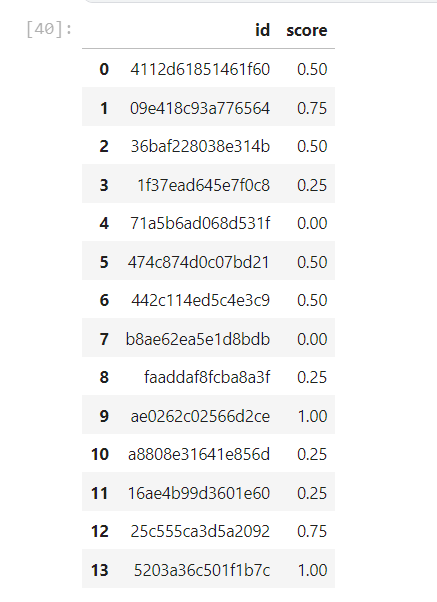

In [41]:
submission.to_csv('submission.csv', index=False)

Interestingly, even with the deberta-v3-small model, we achieved a very decent results as compared to larger pre-trained models on the leaderboard.

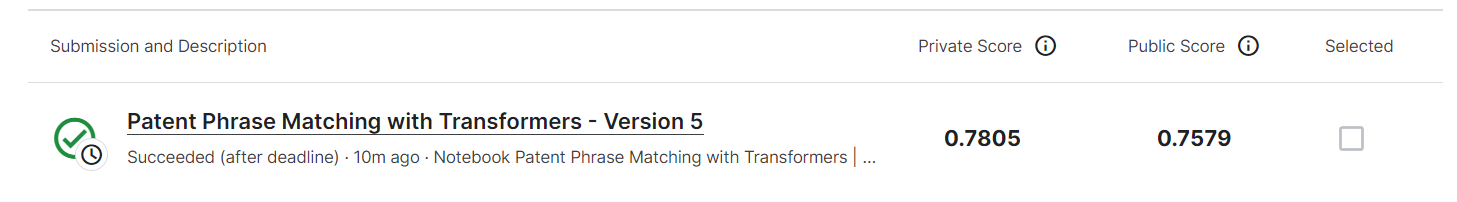

# Discussion

## Hyperparameter Tuning

* Initial Baseline: Started with default parameters or recommendations from model documentation to establish a baseline performance.

* Learning Rate (8e-5): Tried different learning rates and 8e-5 was chosen as it provided a balance between fast convergence and avoiding overshooting the minimum of the loss function. It was observed that higher rates like those we see in assignments were way too high and led to severe overshooting while lower rates slowed down the learning process without improving the correlation much but require more epochs.
    
* Scheduler (Cosine): Tried different schedulers (e.g., constant, linear, cosine). Cosine scheduler smoothly decreases the learning rate, which helped in gently fine-tuning the pretrained weights without causing drastic updates that could harm the pretrained knowledge.
        
* Batch Size (256): Experimented with various batch sizes to balance between computational efficiency and model performance. Decreasing the batch size can significantly reduce memory usage. However, this might affect the convergence and performance of the model. This size was found to be the largest that fit into the memory limits of the 15.9gb constraint on Kaggle, allowing for efficient training.
    
* Number of Epochs (5): Determined the optimal number of training cycles to prevent both underfitting and overfitting. This number was sufficient for the model to converge without overfitting, as evidenced by monitoring validation loss and performance metrics. More epochs did not significantly improve performance on correlations, indicating a point of diminishing returns.
    
* Weight Decay (0.01): Adjusted weight decay as a form of L2 regularization to control model complexity and prevent overfitting. Added to prevent overfitting, especially considering the complexity of the DeBERTa model. This value struck a balance between regularization and allowing the model to adjust its weights sufficiently although I could have tuned it to finer decimal points.

* FP16 (False): This could be set to True for mixed precision training, offering faster training and reduced memory usage without significant loss in model accuracy. However, I found that I could not run it for submission and had to change it to false.

## Optimisation and GPU Constraints

I thought that a huge learning point was on optimisation and the GPU constraints on Kaggle.

* Reduced batch size: see hyperparameter tuning above.

* More Workers: Increasing the number of workers (num_workers) can speed up the data loading process, as it allows more parallel data loading. However, this is only beneficial up to a point. Beyond a certain number of workers, you might not see significant improvements, and it might even slow down due to increased overhead in managing multiple worker processes. It is really hard to gauge the balance but all I did was re-running until I see the epoch time reduced. However, this was adjusted to 1 for submission because of errors in actual submission notebook.

* Use pin_memory in DataLoader: When creating the DataLoader instance for this dataset, using pin_memory=True can speed up the transfer of data from CPU to GPU. 

Also, initially, I started with the DeBERTA V3 Large but faced way too many issues for a learning purpose and hyperparameter tuning. Subsequently, I utilise microsoft/deberta-v3-small instead of the large one. The "small" version of DeBERTa V3 has fewer parameters and layers compared to the "large" version. This means that the small model is a scaled-down version, designed to be more computationally efficient and faster to train, while the large model has a greater capacity to learn complex patterns due to its increased size and complexity.

Specifics: The DeBERTa V3 small model comes with 6 layers and a hidden size of 768. It has 44M backbone parameters with a vocabulary containing 128K tokens which introduces 98M parameters in the Embedding layer. 

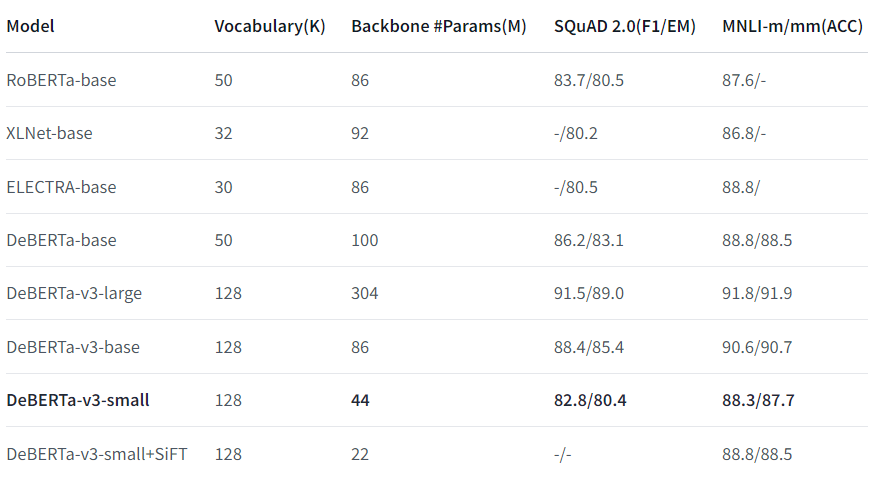

Ref: https://huggingface.co/microsoft/deberta-v3-small

# Takeaways

Learning:

* Enlisting pre-trained models: I thought I really gained a deep understanding of the DeBERTa V3 model, its architecture, and why it is effective for semantic similarity tasks. I also learnt about tokenization and its importance in preparing data for transformer models. Lastly, the exposure also allow me to dive deeper into huggingface and their discord to explore the whole of pre-trained models which really impresses upon me how I could use these models for transfer learning in specified tasks.

* Experimentation: The best way to find the hyperparameters is through experimentation. You can try different values and observe the impact on training speed and system performance even before looking at the results. This also includes understanding the CPU and GPU utilization during training. Honestly, my biggest takeaway is the insights into computational constraints and how to optimize models within these constraints. I think this have real world implications because deploying production-level models would often entail optimisation to ensure resource efficiency.

Improvements:

* Further Hyperparameter Tuning: While significant manual tuning was done, there's always room to explore more combinations or use automated hyperparameter optimization tools like Optuna which I found others have utilised in improving their scores. 

* Experimenting with Other Models and Ensemble methods: With the exposure to models on hugging face, I thought that it is wonderful to explore other transformer models like RoBERTa, XLNet, or very computational efficient models like SetFit to compare performance with DeBERTa. Besides that, I also see a few kagglers using ensemble methods, combining predictions from multiple models to potentially improve accuracy and robustness.

* More Advanced Preprocessing and custom model building: Besides model utilisation, quite a few kagglers use advanced text preprocessing techniques like custom tokenizers tailored for the patent domain. I also see them modifying pre-trained models with custom parameters and architecture in creative ways of transfer learning. I thought that such optimisation really enlightened me on how to truly improve model performance in the future.